In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

In [5]:
data = pd.read_csv("data.csv")
data.head()

,name,inventory,price,price_correspondance,collection,item_url
0,"HALEEM MIX, AHMED",-99,$4.75,'/products/haleem-mix-ahmed',ahmed,https://www.ajijo.com.au/collections/ahmed/pro...
1,"FRUIT CHAT MASALA, AHMED, 50G",8,$1.80,'/products/fruit-chat-masala-ahmed',ahmed,https://www.ajijo.com.au/collections/ahmed/pro...
2,"DAHI BARA MASALA, AHMED, 50G",8,$1.80,'/products/dahi-bara-masala-ahmed',ahmed,https://www.ajijo.com.au/collections/ahmed/pro...
3,"CHICKEN MASALA, AHMED, 50G",1,$1.80,'/products/chicken-masala-ahmed',ahmed,https://www.ajijo.com.au/collections/ahmed/pro...
4,"CHANA MASALA, AHMED, 50G",1,$1.80,'/products/chana-masala-ahmed',ahmed,https://www.ajijo.com.au/collections/ahmed/pro...


In [6]:
# Pre-processing

# Inventory Available but unknown
data.loc[data.inventory == -99, 'inventory'] = np.random.randint(5, 25, len(data.loc[data.inventory == -99, 'inventory']))
# Product Out of Stock
data.loc[data.inventory == -199, 'inventory'] = 0
# Clean Price Column
data['price'] = data['price'].str.replace("$", "").astype(float)

In [7]:
# Create Stores
ajijo = data.sample(int(0.65 * len(data))).reset_index(drop=True)
bharat = data.copy()

# Full Stock for Bharat
bharat.loc[:, 'inventory'] = (bharat['inventory'] + 5) * 5

In [15]:
# Find Closest Store
def find_closest_store(store_locations, customer_locations):
    
    distance_list = []
    stores = []
    for store_name, store_location in store_locations.items():
        distances = np.sqrt(np.sum((store_location - customer_locations)**2, axis=1))
        distance_list.append(distances)
        stores.append(store_name)

    closest_store = [stores[i] for i in np.argmin(distance_list, axis=0)]
    
    return closest_store

# Plot Closest Store to Customers
def plot_closest_store(store_locations, customer_locations):
    
    closest_store = find_closest_store(store_locations, customer_locations)
    
    plt.figure(figsize=(10,5))

    for k,v in store_locations.items():
        plt.scatter(v[0], v[1], label = k.upper(), marker='*', s = 200)

    plt.scatter(customer_locations[:,0], customer_locations[:,1], c='black', alpha=0.3, label='customers')

    for i, store in enumerate(closest_store):
        plt.plot([store_locations[store][0], customer_locations[i, 0]],
                 [store_locations[store][1], customer_locations[i,1]], color = 'orange', alpha=0.1)

    plt.legend(loc='best')
    plt.title("Indian Grocery Stores in Canberra")
    plt.show()

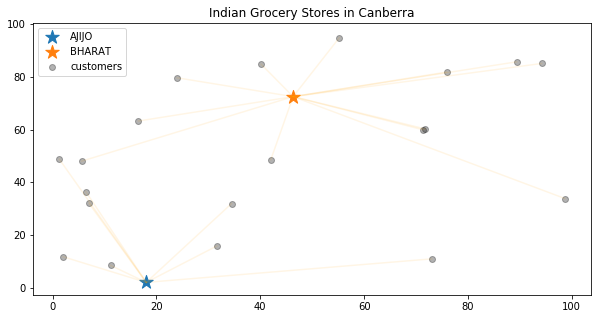

In [16]:
np.random.seed(11)
stores = ['ajijo', 'bharat']
store_locations = {store : np.random.random(2)*100 for store in stores}

n_customers = 20
customer_locations = np.random.random((n_customers, 2))*100
# Simulate n customers (for 1 day)
customers = [np.random.randint(0, len(data), np.random.randint(1, 15)) for i in range(n_customers)]

plot_closest_store(store_locations, customer_locations)

In [17]:
customers

[array([509,  48, 303]),
 array([1064]),
 array([452, 929, 385, 991, 418,  19, 224, 338, 443]),
 array([ 840, 1062,  119,  756,  868,  924,  185,  321,   90,  630,  362,
         145,  367,  842]),
 array([963, 931, 465, 518, 314, 805, 603, 252]),
 array([ 10,  64, 945]),
 array([215]),
 array([140, 506, 886, 343, 529, 241, 981, 947,  35, 766, 450, 619]),
 array([ 435,   15, 1056]),
 array([555, 787, 727, 818, 585, 141, 930,  76, 511]),
 array([ 493,  114, 1014,  987, 1066, 1066,  955,   17,  383,  849,  630,
         459,  811,  734]),
 array([721,  91]),
 array([252, 978, 758, 385, 934, 969, 986, 114, 367]),
 array([  59,  596,  313,  283, 1029,  979,  705,  889,  249,  226]),
 array([705]),
 array([206]),
 array([706, 578]),
 array([ 491,  138,  555,  894,  256,  471, 1048,  487,  883, 1069]),
 array([193, 999, 478, 743, 233]),
 array([1037, 1060,  507,   51,  350, 1054,  747,  379, 1020,  208,  227])]

In [18]:
def shop_at_store(store_customers, store_name):
    
    store = ajijo.copy() if store_name == 'ajijo' else bharat.copy()
    # Simulation Logs
    revenue = 0 # From sales
    revenue_lost = 0 # Due to missing stock
    disappointed_customer_count = 0 # To log the number of customers who didn't get what they came looking for

#     # Simulate n customers (for 1 day)
#     customers = [np.random.randint(0, len(store), np.random.randint(1, 15)) for i in range(n_customers)]

    for customer in store_customers:
        
        try:
            # Purchased items (increase revenue and reduce stock)
            revenue_lost -= store.loc[customer, 'price'][store.inventory <= 0].sum() # Calculate revenue lost due to low stock
            revenue += store.loc[customer, 'price'][store.inventory > 0].sum() # Calculate revenue from sales
            store.loc[customer, 'inventory'] = store.loc[customer, 'inventory'] - 1 # Update the inventory
            if len(store.loc[customer, 'price'][store.inventory <= 0]) > 0:
                disappointed_customer_count += 1
        except:
            disappointed_customer_count += 1
            
    # Calculate percentage of potential revenue lost due to unavailability of products
    pl_inventory_perc = revenue_lost / revenue * 100 if revenue > 0 else 0
    pl_inventory_perc = np.round(pl_inventory_perc, 2)
    
    # Revenue if the items had been available
    potential_revenue = np.round(revenue - revenue_lost, 2)
    
    # Actual Revenue
    revenue = np.round(revenue, 2)
    
    return list((revenue, potential_revenue, pl_inventory_perc, disappointed_customer_count))

#### When ALL customers come to 1 store
#### They only buy if the store has ALL the items that they want, else they are disappointed and leave

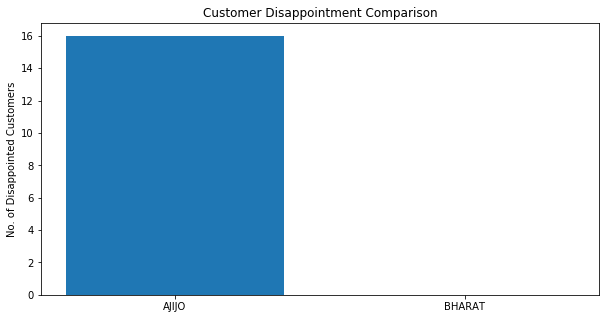

In [21]:
# When all customers come to 1 store
# They only buy if the store has all the items that they want, else they are disappointed and leave
ajijo_stats = shop_at_store(customers, 'ajijo')
bharat_stats = shop_at_store(customers, 'bharat')

plt.figure(figsize=(10,5))
plt.bar(['AJIJO', 'BHARAT'], [ajijo_stats[-1], bharat_stats[-1]], width=0.75)
plt.title("Customer Disappointment Comparison")
plt.ylabel("No. of Disappointed Customers")
plt.show()

#### Location Based

In [20]:
ajijo_stats = shop_at_store(ajijo_customers, 'ajijo')

fig, ax = plt.subplots(1,2, figsize=(20,7))

fig.suptitle("AJIJO", fontsize=16)
ax[0].bar(['Actual', 'Potential'], [ajijo_stats[0], ajijo_stats[1]])
ax[0].set_title("Revenue with {} customers".format(len(ajijo_customers)))

ax[1].pie([len(ajijo_customers) - ajijo_stats[-1], ajijo_stats[-1]], colors=['blue', 'red'])
ax[1].set_title("Estimating Customer Satisfaction")
ax[1].legend(['Satisfied', 'Disappointed'], loc='best')

plt.show()

NameError: name 'ajijo_customers' is not defined

In [22]:
bharat_stats = shop_at_store(bharat_customers, 'bharat')

fig, ax = plt.subplots(1,2, figsize=(20,7))

fig.suptitle("Bharat International", fontsize=16)
ax[0].bar(['Actual', 'Potential'], [bharat_stats[0], bharat_stats[1]])
ax[0].set_title("Revenue with {} customers".format(len(bharat_customers)))

ax[1].pie([len(bharat_customers) - bharat_stats[-1], bharat_stats[-1]], colors=['blue', 'red'])
ax[1].set_title("Estimating Customer Satisfaction")
ax[1].legend(['Satisfied', 'Disappointed'], loc='best')

plt.show()

NameError: name 'bharat_customers' is not defined

In [23]:
def customers_go_to_store(closest_store, customer_carts):
    ajijo_customer_ids = [i for i, store_name in enumerate(closest_store) if store_name == 'ajijo']
    ajijo_customers = [order for i, order in enumerate(customer_carts) if i in ajijo_customer_ids]

    bharat_customer_ids = [i for i, store_name in enumerate(closest_store) if store_name == 'bharat']
    bharat_customers = [order for i, order in enumerate(customer_carts) if i in bharat_customer_ids]
    return ajijo_customers, bharat_customers

In [24]:
def simulate_indian_grocery_shopping(num_runs):
    
    # Set environment
    np.random.seed(11)
    stores = ['ajijo', 'bharat']
    store_locations = {store : np.random.random(2)*100 for store in stores}

#     # Total number of days to simulate
#     num_runs = 14

    # Number of shoppers for each day of the simulation (anywhere between 1 to 100)
    max_n_shoppers = 50 # Maximum number of shoppers on any given day
    num_shoppers = np.random.randint(1, max_n_shoppers, size=num_runs)

    # Log Table 
    columns = ['day_no', 'total_customers', 'store_customers', 'store_name',
               'revenue_actual', 'revenue_potential', 'pl_perc', 'num_disappointed']
    logs = pd.DataFrame()

    # Looping over each day
    for day, n_customers in enumerate(num_shoppers):

        clear_output(wait=True)
        # Customer Location and Shopping Lists
        customer_locations = np.random.random((n_customers, 2))*100
        customer_carts = [np.random.randint(0, len(data), np.random.randint(1, 15)) for i in range(n_customers)]

        # Find closest store for all customers
        closest_store = find_closest_store(store_locations, customer_locations)

        # Send order to store
        orders = customers_go_to_store(closest_store, customer_carts)

        # Go Shopping
        for order, store_name in zip(orders, stores):
            day_stats = [day + 1, n_customers, len(order), store_name]
            shopping_stats = shop_at_store(order, store_name)

            day_data = [day_stats + shopping_stats]
            day_data = pd.DataFrame(day_data, columns=columns)
            logs = pd.concat((logs, day_data))

        progress = (day + 1) / num_runs * 100
        print("Shopping Simulation Progress : {} %".format(np.round(progress ,2)))

    return logs.reset_index(drop=True)

#### Simulation 1

**Conditions :** 
1. Unstable Inventory for Ajijo
2. Full Inventory for Bharat

In [25]:
data = pd.read_csv("data.csv")

# Pre-processing

# Inventory Available but unknown
data.loc[data.inventory == -99, 'inventory'] = np.random.randint(5, 25, len(data.loc[data.inventory == -99, 'inventory']))
# Product Out of Stock
data.loc[data.inventory == -199, 'inventory'] = 0
# Clean Price Column
data['price'] = data['price'].str.replace("$", "").astype(float)

# Create Stores
ajijo = data.sample(int(0.65 * len(data))).reset_index(drop=True)
bharat = data.copy()

# Full Stock for Bharat
bharat.loc[:, 'inventory'] = (bharat['inventory'] + 5) * 5

simulation_results = simulate_indian_grocery_shopping(10000)

KeyboardInterrupt: 

#### Simulation 2

**Conditions :** 
1. Full Inventory for Ajijo
2. Full Inventory for Bharat

In [ ]:
data = pd.read_csv("data.csv")

# Pre-processing

# Inventory Available but unknown
data.loc[data.inventory == -99, 'inventory'] = np.random.randint(5, 25, len(data.loc[data.inventory == -99, 'inventory']))
# Product Out of Stock
data.loc[data.inventory == -199, 'inventory'] = 0
# Clean Price Column
data['price'] = data['price'].str.replace("$", "").astype(float)

# Create Stores
ajijo = data.sample(int(0.65 * len(data))).reset_index(drop=True)
bharat = data.copy()

# Full Stock for Bharat AND AJIJO
bharat.loc[:, 'inventory'] = (bharat['inventory'] + 5) * 5
ajijo.loc[:, 'inventory'] = (ajijo['inventory'] + 5) * 5

simulation_results = simulate_indian_grocery_shopping(10000)

In [396]:
# simulation_results.to_csv("Location Based Shopping Data with Full Inventory (10000 days, 1-50 cpd).csv", index=False)